# Generates the readout's coefficients 
## It uses the simulation output from created in the notebook: BEE_Simulator_ArmControl_VREP_LSM_DATA-GENERATOR.ipynb

### The linear regression shows us that it's important to have a good learning here (seen through the generated curves using the calculated weights on the training set), but a good learning DOES NOT guaranties a good performance during the testing phase.

In [17]:
# Makes possible to show the output from matplotlib inline
%matplotlib inline

import matplotlib.pyplot as plt

# Makes the figures in the PNG format:
# For more information see %config InlineBackend
%config InlineBackend.figure_formats=set([u'png'])

plt.rcParams['figure.figsize'] = 5, 10

import numpy
import sys
import os

from sklearn import linear_model

import save_load_file as slf

import membrane_lowpass_md
membrane_lowpass = membrane_lowpass_md.membrane_lowpass

import time

In [3]:
# Loads the modules and starts the object to be used with the parallel processing iPython stuff...

# Remember to start the clusters:
# https://ipyparallel.readthedocs.org/en/latest/process.html

from ipyparallel import Client

cli = Client()

lbview = cli.load_balanced_view()
# dview = cli[:]

In [4]:
#
# Controls if the results are saved to a file
#

save2file = False

In [7]:
#
# This is the low-pass filter (neuron membrane) applied to the outputs:
membrane_time_constant = 30E-3

# Reducing this value reduces the "memory" of the membrane.

NofN = 20*5*6 # total number of neurons in the output
sim_step_time = 2E-3 #simulation step time (in seconds)

base_dir = "BaxterArm_VREP_simulation_data"
sim_set = "circle"

total_trials_available = 100

total_trials = 100 # This value must be the same number of files (trials) generated
                   # in BEE_Simulator_ArmControl_VREP_LSM_DATA-GENERATOR.ipynb

number_of_trajectories = 1

disconnected = False

ORIGINAL = True

size_distr=10000

In [8]:
trial_array = numpy.arange(1,total_trials_available+1,dtype=numpy.int)
# numpy.random.shuffle(trial_array)

In [9]:
#
# Creates a function to read the spikes in a (multiple process) parallel way.
#
@lbview.parallel(block=True)
def reads_files(filename):
    import save_load_file as slf 
    return slf.load_from_file_gz(filename)

In [10]:
#
# Here the liquid index is defined
#
# REMEMBER: it goes from ZERO to (number_of_liquids-1)

lsm_i = 0

In [18]:
%%time

# 
# Loads the spikes generated by the liquid with index=lsm_i
# 

filenames = []
output_spikes_simulation = []
for pos_i in xrange(number_of_trajectories):
    for run_i in trial_array[:total_trials]:
        if ORIGINAL: # values from the TRAINING SET
            filenames.append(os.getcwd()+"/"+base_dir+"/"+sim_set+"/Joint_Angles"+str(pos_i)+"_LSM_"+str(lsm_i)+"_"+str(run_i)+".gzpickle")
        else: # values from the TESTING set
            filenames.append(os.getcwd()+"/"+base_dir+"/"+sim_set+"/Joint_Angles"+str(pos_i)+"_LSM_RE_"+str(run_i)+".gzpickle")
        # The format of simulated_values is (a list of tuples):
        # [
        # current time (in ms),    =>index 1
        # numpy.array with spikes, =>index 2
        # ]
    output_spikes_simulation.append(reads_files.map(filenames))

CPU times: user 468 ms, sys: 116 ms, total: 584 ms
Wall time: 2.7 s


In [19]:
# 
# Prints some values (first and last time steps), just to make sure it worked...
#

print output_spikes_simulation[0][0][0]

print output_spikes_simulation[0][-1][-1]

[0, array([], dtype=int32)]
[1.9980000000000016, array([  1,   4,   7,   9,  14,  19,  30,  41,  44,  49,  58,  59,  62,
        70,  71,  72,  76,  78,  81,  82, 100, 107, 108, 110, 118, 122,
       126, 128, 129, 133, 142, 145, 146, 151, 153, 154, 157, 161, 163,
       176, 189, 190, 197, 200, 222, 223, 227, 234, 238, 239, 242, 243,
       244, 246, 257, 260, 261, 272, 275, 286, 296, 306, 307, 311, 318,
       326, 329, 331, 339, 343, 345, 349, 350, 354, 355, 363, 364, 367,
       369, 372, 374, 375, 377, 381, 389, 392, 401, 405, 415, 421, 423,
       427, 430, 433, 441, 442, 446, 454, 455, 463, 466, 471, 472, 475,
       489, 495, 496, 503, 513, 516, 517, 520, 526, 532, 537, 546, 547,
       551, 552, 559, 561, 567, 595, 598], dtype=int32)]


## Information about the simulation is extracted directly from data:
```output_spikes_simulation[X] => all the simulated values for the trajectory X+1
output_spikes_simulation[X][Y] => the simulated values for trial Y+1 of the trajectory X+1
output_spikes_simulation[X][Y][Z] => the output spikes for the step Z of the simulated values 
                                     for trial Y+1 of the trajectory X+1
total_trajectories => len(output_spikes_simulation)
total_trials => len(output_spikes_simulation[0]),
total_steps => len(output_spikes_simulation[0][0][:])
sim_step_time => (output_spikes_simulation[0][0][1][0]-output_spikes_simulation[0][0][0][0])```


In [20]:
total_trajectories,total_trials,_total_steps,sim_step_time = len(output_spikes_simulation),len(output_spikes_simulation[0]),len(output_spikes_simulation[0][0]), (output_spikes_simulation[0][0][1][0]-output_spikes_simulation[0][0][0][0])
total_trajectories,total_trials,_total_steps,sim_step_time

(1, 100, 1000, 0.002)

In [21]:
#
# It's important to pay attention to this:
#
total_steps=_total_steps-1
print "total_steps =",total_steps

# The readout is trained to recognise the NEXT value based on the past.
# That's why the first step is missed (there's no past as the network states are random or zero)

total_steps = 999


In [22]:
# Generates the FILTERED (membrane low-pass filter) data to be used with the linear regression
# The first index of the matrix is the trajectory
# Example (each trajectory has 250 steps): 
# linalg_matrix_filtered[0][0:250] => is the first experiment of the first trajectory
# linalg_matrix_filtered[0][250:250*2] => is the second experiment of the first trajectory

avoid_n = 0 # Avoids the avoid_n steps after step=0 (always ignored)
            # This type of LSM receives during the first N steps the correct values before it
            # starts generating the rest of the time series.
            # N = avoid_n+1

# t_idx = 0 # 0=>first trajectory
# e_idx = 0 # 0=>first experiment
linalg_matrix_filtered = numpy.zeros((total_trajectories, total_trials*(total_steps-avoid_n), NofN),dtype=numpy.float)

for t_idx in range(total_trajectories): # goes through all the trajectories
    for e_idx in range(total_trials): # goes through all the trials
        m_v=membrane_lowpass(NofN,membrane_time_constant) # Initialize the membrane for each new trial
        for i in range(1,total_steps): # ignores the first output from the network (noisy, uncorrelated with input)
            if (output_spikes_simulation[t_idx][e_idx][i][1]).size>0:
                m_v.process_spikes(output_spikes_simulation[t_idx][e_idx][i][1],\
                                   output_spikes_simulation[t_idx][e_idx][i][0])
            if i >= avoid_n: #useless as i starts at 1 and avoid_n=1...
                linalg_matrix_filtered[t_idx][(i-avoid_n)+\
                                              (total_steps-avoid_n)*e_idx]=m_v.check_values(i*sim_step_time) # Saves the membrane state at each time step
linalg_matrix_filtered.shape

# This is another good candidate to be vectorized...

(1, 99900, 600)

# Defines the outputs to be learned

In [23]:

original_joints=numpy.zeros((0,4)) #creates an empty array with the right shape...


temp=numpy.load(base_dir+"/"+sim_set+"/XY_movement_"+sim_set+".npy")
original_joints=numpy.concatenate((original_joints,temp[:1000]))


Now I need to read the CORRECT joint values to be used with the linear regression

In [24]:
# Reads all the experiments to check which range of values is necessary to control the arm.
# At the first step (0) the network always returns zero spikes. So it's impossible to fit anything there, but zero.
# When step=0, the SNN should calculate the next value, or step+1, but because the output is zero, the
# SNN must receive this next step.
# Consequently, the SNN needs the values for step=0 and step=1 before it could be able to generate the next ones.
number_of_joints = 4
joints_all = numpy.zeros((total_steps-avoid_n,number_of_trajectories,number_of_joints),dtype=numpy.float)
for i in xrange(number_of_trajectories):
    joints=numpy.copy(original_joints)
    for j in range(number_of_joints):
        joints_all[:total_steps-avoid_n,i,j]=joints[avoid_n+1:,j] # [2:,j]
joints_all.shape

(999, 1, 4)

## After this point the original data is shorter as I need to offset the values in order to give the network N initial values before it starts generating the curves (N=avoid_n+1).
## Because of this situation the BIAS calculated here is not always the first value, but the N and the RANGES also ignore the first N values.

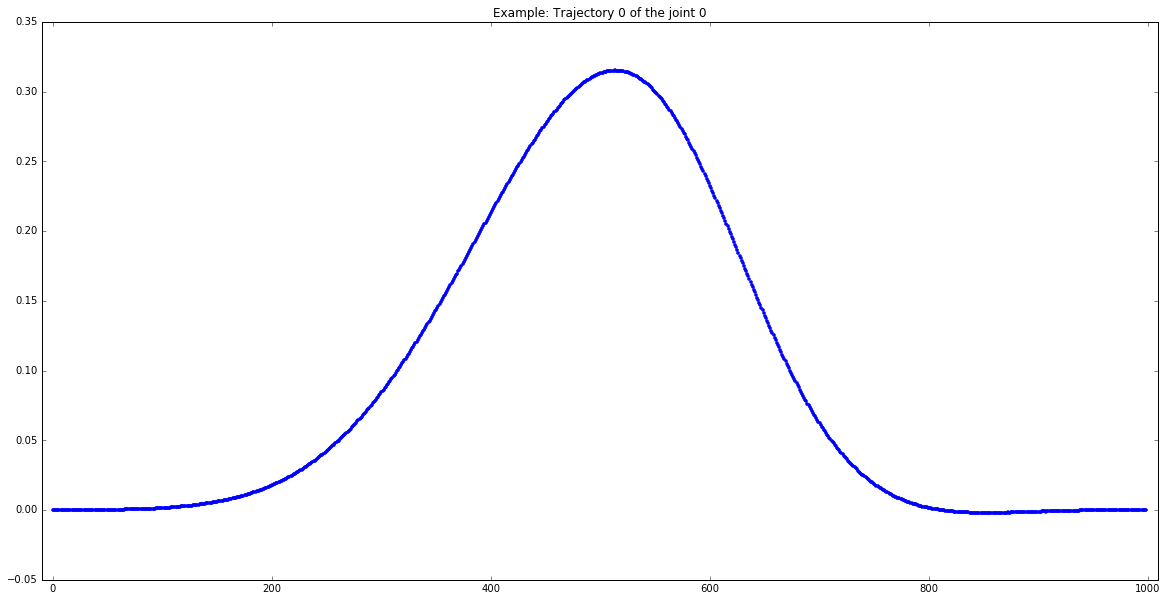

In [25]:
tji=0
ji=0
plt.figure(figsize=(20,10))
plt.plot(joints_all[:,tji,ji]-joints_all[0,tji,ji],'.')
plt.xlim(-10,joints_all.shape[0]+10)
plt.title("Example: Trajectory "+str(tji)+" of the joint "+str(ji))
plt.show()

In [26]:
# Using the idea of starting/finishing with a zero value.
#

y_s0=[]
y_s1=[]
y_e1=[]
y_w1=[]
for tji in range(number_of_trajectories):
    
    # Signal conditioning
    temp_s0=joints_all[:,tji,0]-joints_all[0,tji,0] #extract the bias
    s0_range=(temp_s0.max()-temp_s0.min()) #calculates the range after extracting the bias
    temp_s0=temp_s0/s0_range #normalizes the total range from 0 to 1

    temp_s1=joints_all[:,tji,1]-joints_all[0,tji,1]
    s1_range=(temp_s1.max()-temp_s1.min())
    temp_s1=temp_s1/s1_range

    temp_e1=joints_all[:,tji,2]-joints_all[0,tji,2]
    e1_range=(temp_e1.max()-temp_e1.min())
    temp_e1=temp_e1/e1_range

    temp_w1=joints_all[:,tji,3]-joints_all[0,tji,3]
    w1_range=(temp_w1.max()-temp_w1.min())
    temp_w1=temp_w1/w1_range

    bias_vector = joints_all[0,tji,:]

    print "Bias vector:", bias_vector
    if save2file:
        slf.save_to_file(bias_vector,"./"+base_dir+"/"+sim_set+"/bias_"+str(tji)+".pickle")    

    print "Ranges vector (output):", [s0_range,s1_range,e1_range,w1_range]      
    if save2file:
        slf.save_to_file([s0_range,s1_range,e1_range,w1_range],"./"+base_dir+"/"+sim_set+"/ranges_"+str(tji)+".pickle")
        
    # Here I'm concatenating all trials (repeating the values) in one list for each joint
    for ti in range(total_trials):
        y_s0=numpy.concatenate((y_s0,temp_s0))
        y_s1=numpy.concatenate((y_s1,temp_s1))
        y_e1=numpy.concatenate((y_e1,temp_e1))
        y_w1=numpy.concatenate((y_w1,temp_w1))

Bias vector: [-0.94075072 -0.58277339  1.7745688   0.41333145]
Ranges vector (output): [0.31721556186676025, 0.14862033724784851, 0.56483888626098633, 0.41670715808868408]


In [27]:
y_s0.shape,y_s1.shape,y_e1.shape,y_w1.shape

((99900,), (99900,), (99900,), (99900,))

# Uses the low-pass filtered outputs:

In [28]:
X_matrix=linalg_matrix_filtered    

In [29]:
X_matrix.shape

(1, 99900, 600)

In [30]:
# Prepare the matrix to be used with numpy linear regression:
X_reshaped=X_matrix.reshape(y_s0.shape[0],NofN)

# Creates an empty matrix with an extra collumn with ones (numpy.linalg.lstsq demands this...)
X_reshaped=numpy.ones((X_reshaped.shape[0],X_reshaped.shape[1]+1))

# Writes the values in to the first NofN collumns
X_reshaped[:,:NofN]=X_matrix.reshape(y_s0.shape[0],NofN)


In [31]:
# Now the reshaped matrix has an extra collumn:
X_reshaped.shape

(99900, 601)

In [32]:
X=X_reshaped

In [33]:
numpy.shape(X)[0]*numpy.shape(X)[1]

60039900

In [34]:
X.max(),X.min(),y_s0.max(),y_s0.min(),y_s1.max(),y_s0.min(),y_e1.max(),y_e1.min(),y_w1.max(),y_w1.min()

(8.0111078203233443,
 0.0,
 0.99342689976726772,
 -0.0065731002327323179,
 0.60282630130195869,
 -0.0065731002327323179,
 0.50048921407484515,
 -0.49951078592515491,
 0.46372103388466562,
 -0.53627896611533432)

In [35]:
X.shape, y_s0.shape

((99900, 601), (99900,))

In [36]:
X[:,-1] # Shows the last column made of ones...

array([ 1.,  1.,  1., ...,  1.,  1.,  1.])

In [227]:
# %%time

# QR FACTORIZATION STUDY

# sklg = linear_model.LinearRegression(fit_intercept=True, normalize=True, copy_X=True, n_jobs=7)

# # Xqr_ex=numpy.concatenate((Xqr,numpy.ones((Xqr.shape[0],1))),axis=1)
# Xqr=numpy.copy(X[:,:NofN])
# q,r=numpy.linalg.qr(Xqr)

# Yqrs0=numpy.copy(y_s0)
# Yqrs1=numpy.copy(y_s1)
# Yqre1=numpy.copy(y_e1)
# Yqrw1=numpy.copy(y_w1)

# QYs0=(q.T).dot(Yqrs0)
# QYs1=(q.T).dot(Yqrs1)
# QYe1=(q.T).dot(Yqre1)
# QYw1=(q.T).dot(Yqrw1)

# sklg.fit(r,QYs0)
# c_s0=sklg.coef_
# r_s0=sklg.intercept_

# sklg.fit(r,QYs1)
# c_s1=sklg.coef_
# r_s1=sklg.intercept_

# sklg.fit(r,QYe1)
# c_e1=sklg.coef_
# r_e1=sklg.intercept_

# sklg.fit(r,QYw1)
# c_w1=sklg.coef_
# r_w1=sklg.intercept_


In [228]:
# @dview.parallel(block=True)
# def solve_linear_regressionQR(arguments):
#     #solve_linear_regression.map(input_list)

#     import numpy
#     from sklearn import linear_model

#     import save_load_file as slf
    
    
#     q,r,y,filename = arguments
    
#     sklg = linear_model.LinearRegression(fit_intercept=True, normalize=True, copy_X=True)
#     # sklg = linear_model.Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
#     #       normalize=False, solver='auto', tol=0.001)
#     # Using sklearn is a lot easier to try another linear model algorithm, I just have to change the above line.
#     # sklg = linear_model.SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,\
#     #                                  fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',\
#     #                                  loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,\
#     #                                  random_state=None, shuffle=True, verbose=0, warm_start=False)

#     # sklg = linear_model.Ridge()
#     # sklg = linear_model.BayesianRidge()
    
#     QY=(q.T).dot(y)
#     sklg.fit(r,QY)

#     slf.save_to_file([sklg.coef_,sklg.intercept_],filename)
    
#     return 1

In [229]:
# X=X[:,:NofN] # Cuts out the extra ones used only for 

# @dview.parallel(block=True)
# def solve_linear_regression(arguments):
#     #solve_linear_regression.map(input_list)

#     import numpy
#     from sklearn import linear_model

#     import save_load_file as slf
    
    
#     X,y,NofN,xnoise,ynoise,filename = arguments
    
# #     sklg = linear_model.LinearRegression(fit_intercept=True, copy_X=True)
# #     sklg = linear_model.LinearRegression(fit_intercept=True, normalize=True, copy_X=True)    
#     # sklg = linear_model.Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
#     #       normalize=False, solver='auto', tol=0.001)
#     # Using sklearn is a lot easier to try another linear model algorithm, I just have to change the above line.
#     # sklg = linear_model.SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,\
#     #                                  fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',\
#     #                                  loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,\
#     #                                  random_state=None, shuffle=True, verbose=0, warm_start=False)

#     sklg = linear_model.Ridge()
#     # sklg = linear_model.BayesianRidge()
    
#     # Robustly fit linear model with RANSAC algorithm
#     ransac=0
# #     sklg = linear_model.RANSACRegressor(linear_model.LinearRegression(fit_intercept=True, copy_X=True))
    

#     if (xnoise and ynoise):
#         NOISE_X = numpy.random.normal(loc=0,scale=xnoise,size=X.shape)
#         NOISE_Y = numpy.random.normal(loc=0,scale=ynoise,size=y.shape)
    
#         sklg.fit(X+NOISE_X,y+NOISE_Y)
#     else:
#         sklg.fit(X,y)

#     if not ransac:
#         slf.save_to_file([sklg.coef_,sklg.intercept_],filename)
#     else:
#         slf.save_to_file([sklg.estimator_.coef_[0,:],sklg.estimator_.intercept_[0]],filename)
    
#     return 1

In [230]:
# # NUMPY VERSION...
# @dview.parallel(block=True)
# def solve_linear_regression(arguments):
#     #solve_linear_regression.map(input_list)

#     import numpy
#     from sklearn import linear_model

#     import save_load_file as slf
    
    
#     X,y,NofN,xnoise,ynoise,filename = arguments
    
#     linear_regression1 = numpy.linalg.lstsq(X, y)
#     c_tau1=linear_regression1[0][:-1] # Coefficients
#     r_tau1=linear_regression1[0][-1]  # Constant
        
#     slf.save_to_file([c_tau1,r_tau1],filename)
    
#     return 1

In [37]:
extra_name=str(lsm_i)

if disconnected:
    extra_name="_unconnected"+extra_name

filenames = ["./"+base_dir+"/"+sim_set+"/coefficients_residues_"+str(var_name)+"_linear"+extra_name+".pickle" \
             for var_name in ['s0','s1','e1','w1']]

In [38]:
print filenames[0]

./BaxterArm_VREP_simulation_data/circle/coefficients_residues_s0_linear0.pickle


In [233]:
# # Tests if the two trials are identical or not...
# input_var = X
# ((input_var[0:input_var.shape[0]/2]==input_var[input_var.shape[0]/2:])==False).any()

In [234]:
# std_x = False
# std_y = False


# inputs_lrsq = [(X,y_s0,NofN,std_x,std_y,filenames[0]),\
#                (X,y_s1,NofN,std_x,std_y,filenames[1]),\
#                (X,y_e1,NofN,std_x,std_y,filenames[2]),\
#                (X,y_w1,NofN,std_x,std_y,filenames[3])]

In [53]:
# # Example of how to add all the outputs together:
# numpy.hstack((numpy.arange(10).reshape((1,10)).T,numpy.ones(10).reshape((1,10)).T))

In [39]:
%%time
# Non parallel linear regression (trying to solve the pickles problem when I have too many trials (more than 300...))
from sklearn import linear_model

X=X[:,:NofN] # Cuts out the extra ones used only for 

sklg = linear_model.Ridge()
y=numpy.hstack((y_s0.reshape((1,y_s0.shape[0])).T,\
                y_s1.reshape((1,y_s1.shape[0])).T,\
                y_e1.reshape((1,y_e1.shape[0])).T,\
                y_w1.reshape((1,y_w1.shape[0])).T))
sklg.fit(X,y)

for fi in range(4):
    if save2file:
        slf.save_to_file([sklg.coef_[fi],sklg.intercept_[fi]],filenames[fi])
    
[c_s0,r_s0] = slf.load_from_file(filenames[0])
[c_s1,r_s1] = slf.load_from_file(filenames[1])
[c_e1,r_e1] = slf.load_from_file(filenames[2])
[c_w1,r_w1] = slf.load_from_file(filenames[3])

CPU times: user 2.81 s, sys: 220 ms, total: 3.03 s
Wall time: 1.04 s


In [237]:
# %%time
# results = solve_linear_regression.map(inputs_lrsq)

# [c_s0,r_s0] = slf.load_from_file(filenames[0])
# [c_s1,r_s1] = slf.load_from_file(filenames[1])
# [c_e1,r_e1] = slf.load_from_file(filenames[2])
# [c_w1,r_w1] = slf.load_from_file(filenames[3])

In [238]:
# %%time
# q,r=numpy.linalg.qr(X[:,:NofN])
# inputs_lrsq_qr = [(q,r,y_s0,filenames[0]),\
#                   (q,r,y_s1,filenames[1]),\
#                   (q,r,y_e1,filenames[2]),\
#                   (q,r,y_w1,filenames[3])]

# results = solve_linear_regressionQR.map(inputs_lrsq_qr)

# [c_s0,r_s0] = slf.load_from_file(filenames[0])
# [c_s1,r_s1] = slf.load_from_file(filenames[1])
# [c_e1,r_e1] = slf.load_from_file(filenames[2])
# [c_w1,r_w1] = slf.load_from_file(filenames[3])

#### Using sklearn I can try a lot of different readouts:
http://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model

In [40]:
s0_calculated=X_matrix.reshape(y_s0.shape[0],NofN).dot(c_s0)+r_s0
s1_calculated=X_matrix.reshape(y_s1.shape[0],NofN).dot(c_s1)+r_s1
e1_calculated=X_matrix.reshape(y_e1.shape[0],NofN).dot(c_e1)+r_e1
w1_calculated=X_matrix.reshape(y_w1.shape[0],NofN).dot(c_w1)+r_w1

In [41]:
X_matrix.shape

(1, 99900, 600)

In [42]:
# This dictionary is used to automate the figures generation
joints_dict={'s0':(y_s0,s0_calculated),'s1':(y_s1,s1_calculated),'e1':(y_e1,e1_calculated),'w1':(y_w1,w1_calculated) }

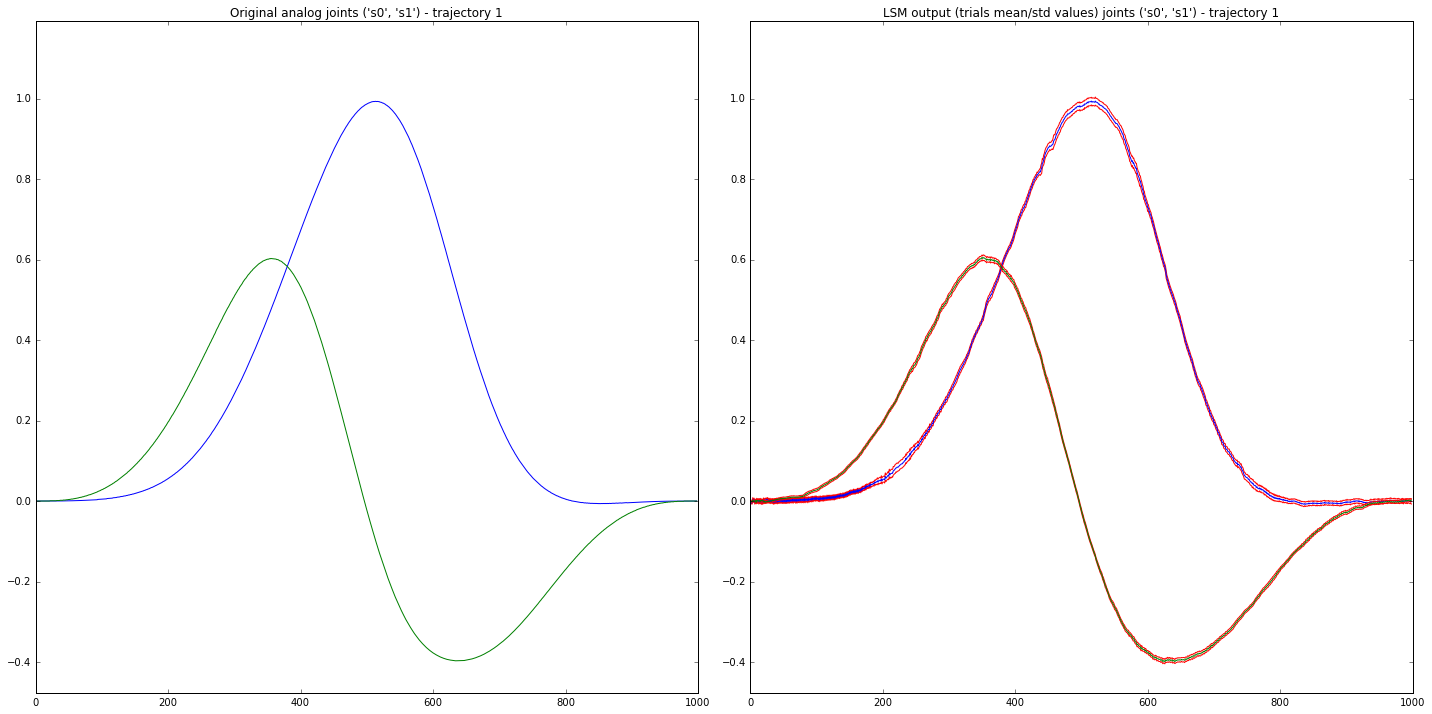

In [43]:
# Plots the inputs and the outputs side-by-side

joints_names = 's0','s1'

y_1 = joints_dict[joints_names[0]][0]
y_2 = joints_dict[joints_names[1]][0]
y1_calculated = joints_dict[joints_names[0]][1]
y2_calculated = joints_dict[joints_names[1]][1]

offset11 = y_1.shape[0]/number_of_trajectories
offset21 = y_2.shape[0]/number_of_trajectories

offset12 = y_1.shape[0]/number_of_trajectories/total_trials
offset22 = y_2.shape[0]/number_of_trajectories/total_trials


fig=plt.figure(figsize =(20,10));

for trajectory in xrange(number_of_trajectories):
# trajectory=0 # goes from 0 to 3

    ymax=numpy.array([y_1[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].max(),y_2[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].max()]).max()
    ymin=numpy.array([y_1[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].min(),y_2[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].min()]).min()

    ymaxLSM=numpy.array([y1_calculated[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].max(),y2_calculated[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].max()]).max()
    yminLSM=numpy.array([y1_calculated[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].min(),y2_calculated[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].min()]).min()


    plt.subplot(number_of_trajectories,2,2*trajectory+1)    
    plt.plot(y_1[trajectory*(offset11):offset11*trajectory+offset12],'b')
    plt.plot(y_2[trajectory*(offset21):offset21*trajectory+offset22],'g')


    plt.ylim(ymin-abs(ymin)/5.,ymax+abs(ymax)/5.)
    plt.title("Original analog joints "+ str(joints_names) +" - trajectory " + str(trajectory+1))

    plt.subplot(number_of_trajectories,2,2*trajectory+2)
    plt.plot(y1_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:].mean(axis=0)+y1_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:].std(axis=0),'r')
    plt.plot(y1_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:].mean(axis=0)-y1_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:].std(axis=0),'r')    
    plt.plot(y1_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:].mean(axis=0),'b')    
    plt.plot(y2_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:].mean(axis=0)+y2_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:].std(axis=0),'r')    
    plt.plot(y2_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:].mean(axis=0)-y2_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:].std(axis=0),'r')        
    plt.plot(y2_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:].mean(axis=0),'g')    
    plt.ylim(ymin-abs(ymin)/5.,ymax+abs(ymax)/5.)
    plt.title("LSM output (trials mean/std values) joints "+ str(joints_names) +" - trajectory " + str(trajectory+1))

# fig.subplots_adjust(bottom=0,hspace=.6) # Adjust the distance between subplots
plt.tight_layout()
# plt.savefig("./"+base_dir+"/"+sim_set+"/readout_test_s0_s1_"+sim_set+".pdf")
plt.show()

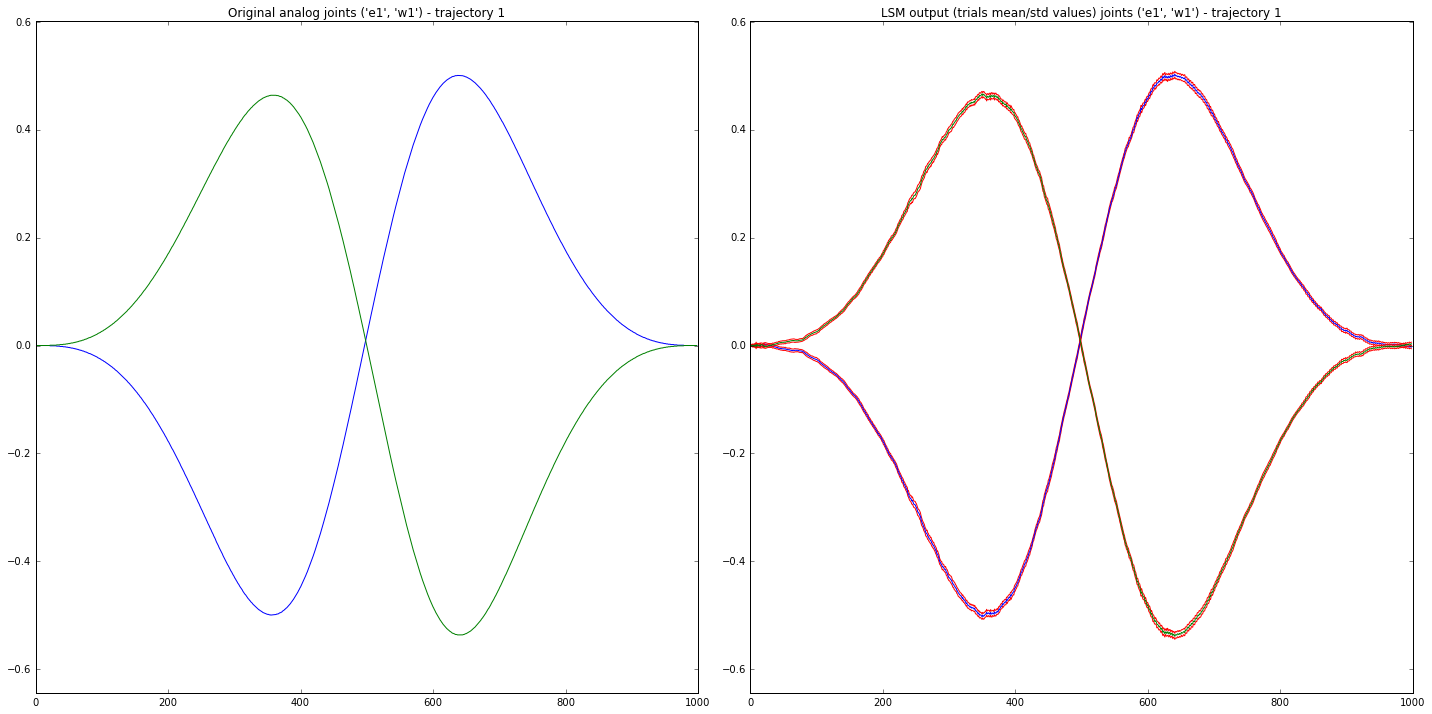

In [44]:
# Plots the inputs and the outputs side-by-side

joints_names = 'e1','w1'

y_1 = joints_dict[joints_names[0]][0]
y_2 = joints_dict[joints_names[1]][0]
y1_calculated = joints_dict[joints_names[0]][1]
y2_calculated = joints_dict[joints_names[1]][1]

offset11 = y_1.shape[0]/number_of_trajectories
offset21 = y_2.shape[0]/number_of_trajectories

offset12 = y_1.shape[0]/number_of_trajectories/total_trials
offset22 = y_2.shape[0]/number_of_trajectories/total_trials


fig=plt.figure(figsize =(20,10));

for trajectory in xrange(number_of_trajectories):
# trajectory=0 # goes from 0 to 3

    ymax=numpy.array([y_1[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].max(),y_2[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].max()]).max()
    ymin=numpy.array([y_1[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].min(),y_2[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].min()]).min()

    ymaxLSM=numpy.array([y1_calculated[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].max(),y2_calculated[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].max()]).max()
    yminLSM=numpy.array([y1_calculated[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].min(),y2_calculated[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].min()]).min()


    plt.subplot(number_of_trajectories,2,2*trajectory+1)    
    plt.plot(y_1[trajectory*(offset11):offset11*trajectory+offset12],'b')
    plt.plot(y_2[trajectory*(offset21):offset21*trajectory+offset22],'g')


    plt.ylim(ymin-abs(ymin)/5.,ymax+abs(ymax)/5.)
    plt.title("Original analog joints "+ str(joints_names) +" - trajectory " + str(trajectory+1))

    plt.subplot(number_of_trajectories,2,2*trajectory+2)
    plt.plot(y1_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:].mean(axis=0)+y1_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:].std(axis=0),'r')
    plt.plot(y1_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:].mean(axis=0)-y1_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:].std(axis=0),'r')    
    plt.plot(y1_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:].mean(axis=0),'b')    
    plt.plot(y2_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:].mean(axis=0)+y2_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:].std(axis=0),'r')    
    plt.plot(y2_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:].mean(axis=0)-y2_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:].std(axis=0),'r')
    plt.plot(y2_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:].mean(axis=0),'g')    
    plt.ylim(ymin-abs(ymin)/5.,ymax+abs(ymax)/5.)
    plt.title("LSM output (trials mean/std values) joints "+ str(joints_names) +" - trajectory " + str(trajectory+1))

# fig.subplots_adjust(bottom=0,hspace=.6) # Adjust the distance between subplots
plt.tight_layout()
# plt.savefig("./"+base_dir+"/"+sim_set+"/readout_test_s0_s1_"+sim_set+".pdf")
plt.show()

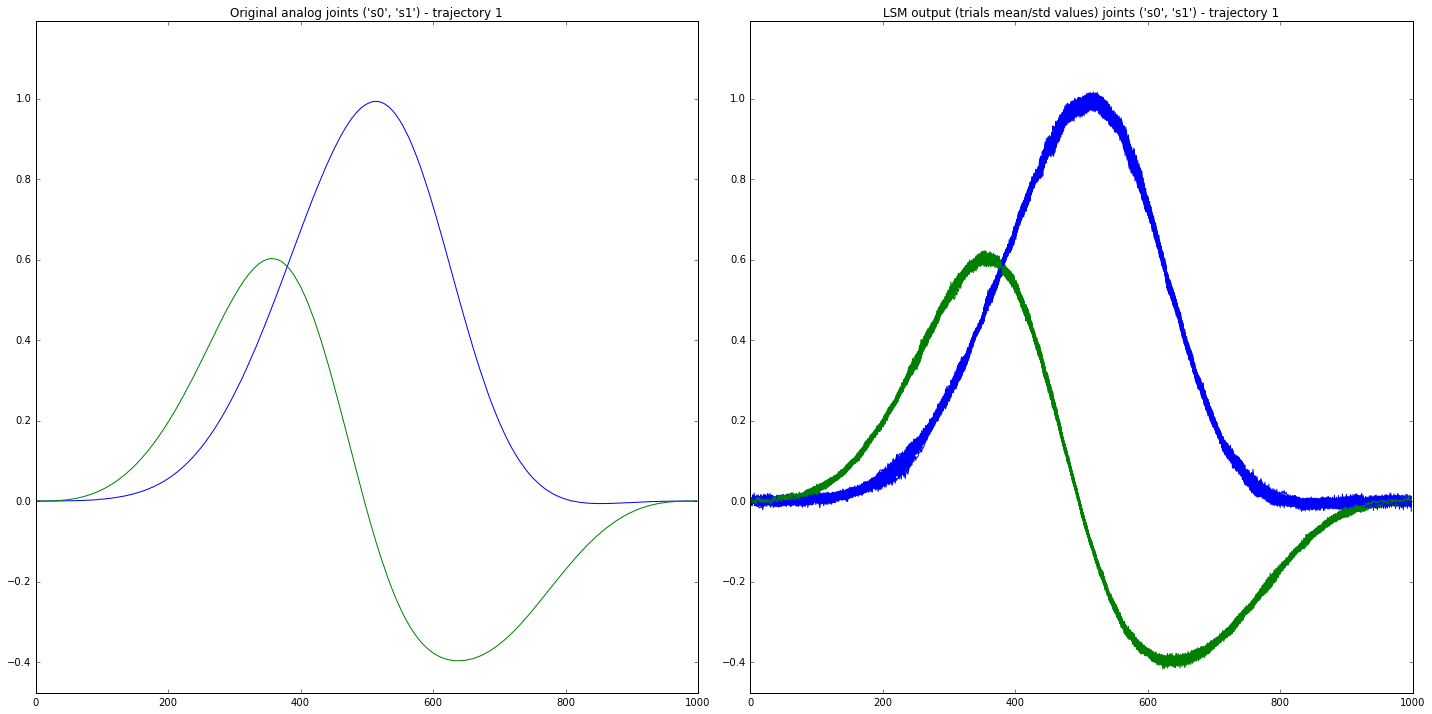

In [45]:
# Plots the inputs and the outputs side-by-side

joints_names = 's0','s1'

y_1 = joints_dict[joints_names[0]][0]
y_2 = joints_dict[joints_names[1]][0]
y1_calculated = joints_dict[joints_names[0]][1]
y2_calculated = joints_dict[joints_names[1]][1]

offset11 = y_1.shape[0]/number_of_trajectories
offset21 = y_2.shape[0]/number_of_trajectories

offset12 = y_1.shape[0]/number_of_trajectories/total_trials
offset22 = y_2.shape[0]/number_of_trajectories/total_trials


fig=plt.figure(figsize =(20,10));

for trajectory in xrange(number_of_trajectories):
# trajectory=0 # goes from 0 to 3

    ymax=numpy.array([y_1[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].max(),y_2[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].max()]).max()
    ymin=numpy.array([y_1[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].min(),y_2[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].min()]).min()

    ymaxLSM=numpy.array([y1_calculated[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].max(),y2_calculated[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].max()]).max()
    yminLSM=numpy.array([y1_calculated[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].min(),y2_calculated[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].min()]).min()


    plt.subplot(number_of_trajectories,2,2*trajectory+1)    
    plt.plot(y_1[trajectory*(offset11):offset11*trajectory+offset12],'b')
    plt.plot(y_2[trajectory*(offset21):offset21*trajectory+offset22],'g')


    plt.ylim(ymin-abs(ymin)/5.,ymax+abs(ymax)/5.)
    plt.title("Original analog joints "+ str(joints_names) +" - trajectory " + str(trajectory+1))

    plt.subplot(number_of_trajectories,2,2*trajectory+2)
    for ci in range(total_trials):
        plt.plot((y1_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:])[ci,:],'b')    
        plt.plot((y2_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:])[ci,:],'g')    
    plt.ylim(ymin-abs(ymin)/5.,ymax+abs(ymax)/5.)
    plt.title("LSM output (trials mean/std values) joints "+ str(joints_names) +" - trajectory " + str(trajectory+1))

# fig.subplots_adjust(bottom=0,hspace=.6) # Adjust the distance between subplots
plt.tight_layout()
# plt.savefig("./"+base_dir+"/"+sim_set+"/readout_test_s0_s1_"+sim_set+".pdf")
plt.show()

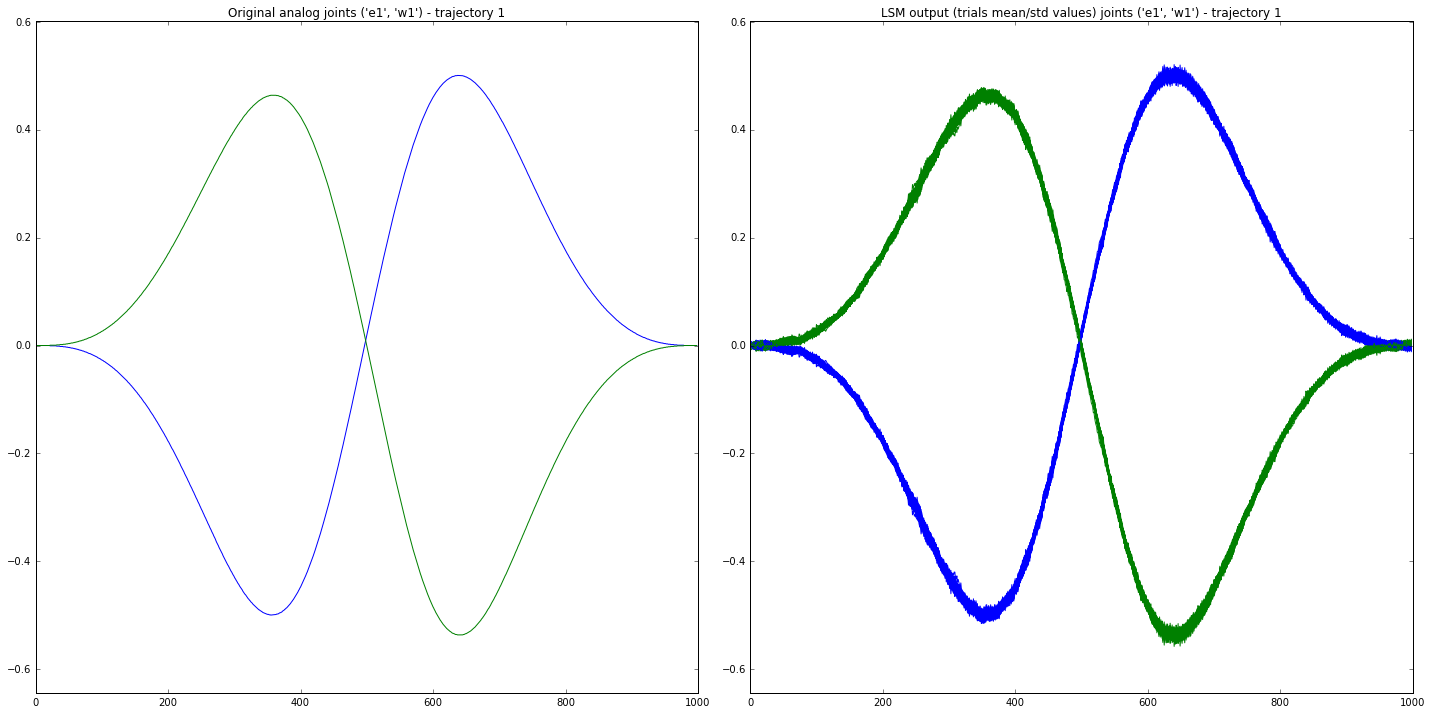

In [46]:
# Plots the inputs and the outputs side-by-side

joints_names = 'e1','w1'

y_1 = joints_dict[joints_names[0]][0]
y_2 = joints_dict[joints_names[1]][0]
y1_calculated = joints_dict[joints_names[0]][1]
y2_calculated = joints_dict[joints_names[1]][1]

offset11 = y_1.shape[0]/number_of_trajectories
offset21 = y_2.shape[0]/number_of_trajectories

offset12 = y_1.shape[0]/number_of_trajectories/total_trials
offset22 = y_2.shape[0]/number_of_trajectories/total_trials


fig=plt.figure(figsize =(20,10));

for trajectory in xrange(number_of_trajectories):
# trajectory=0 # goes from 0 to 3

    ymax=numpy.array([y_1[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].max(),y_2[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].max()]).max()
    ymin=numpy.array([y_1[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].min(),y_2[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].min()]).min()

    ymaxLSM=numpy.array([y1_calculated[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].max(),y2_calculated[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].max()]).max()
    yminLSM=numpy.array([y1_calculated[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].min(),y2_calculated[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].min()]).min()


    plt.subplot(number_of_trajectories,2,2*trajectory+1)    
    plt.plot(y_1[trajectory*(offset11):offset11*trajectory+offset12],'b')
    plt.plot(y_2[trajectory*(offset21):offset21*trajectory+offset22],'g')


    plt.ylim(ymin-abs(ymin)/5.,ymax+abs(ymax)/5.)
    plt.title("Original analog joints "+ str(joints_names) +" - trajectory " + str(trajectory+1))

    plt.subplot(number_of_trajectories,2,2*trajectory+2)
    for ci in range(total_trials):
        plt.plot((y1_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:])[ci,:],'b')    
        plt.plot((y2_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:])[ci,:],'g')    
    plt.ylim(ymin-abs(ymin)/5.,ymax+abs(ymax)/5.)
    plt.title("LSM output (trials mean/std values) joints "+ str(joints_names) +" - trajectory " + str(trajectory+1))

# fig.subplots_adjust(bottom=0,hspace=.6) # Adjust the distance between subplots
plt.tight_layout()
# plt.savefig("./"+base_dir+"/"+sim_set+"/readout_test_s0_s1_"+sim_set+".pdf")
plt.show()

In [47]:
Ninput = 150 # Number of neurons used for the input code
joint_values_normalised = numpy.linspace(-1,1,Ninput)

# [abs(joint_values_normalised-jin).argmin() for jin in XXXX]

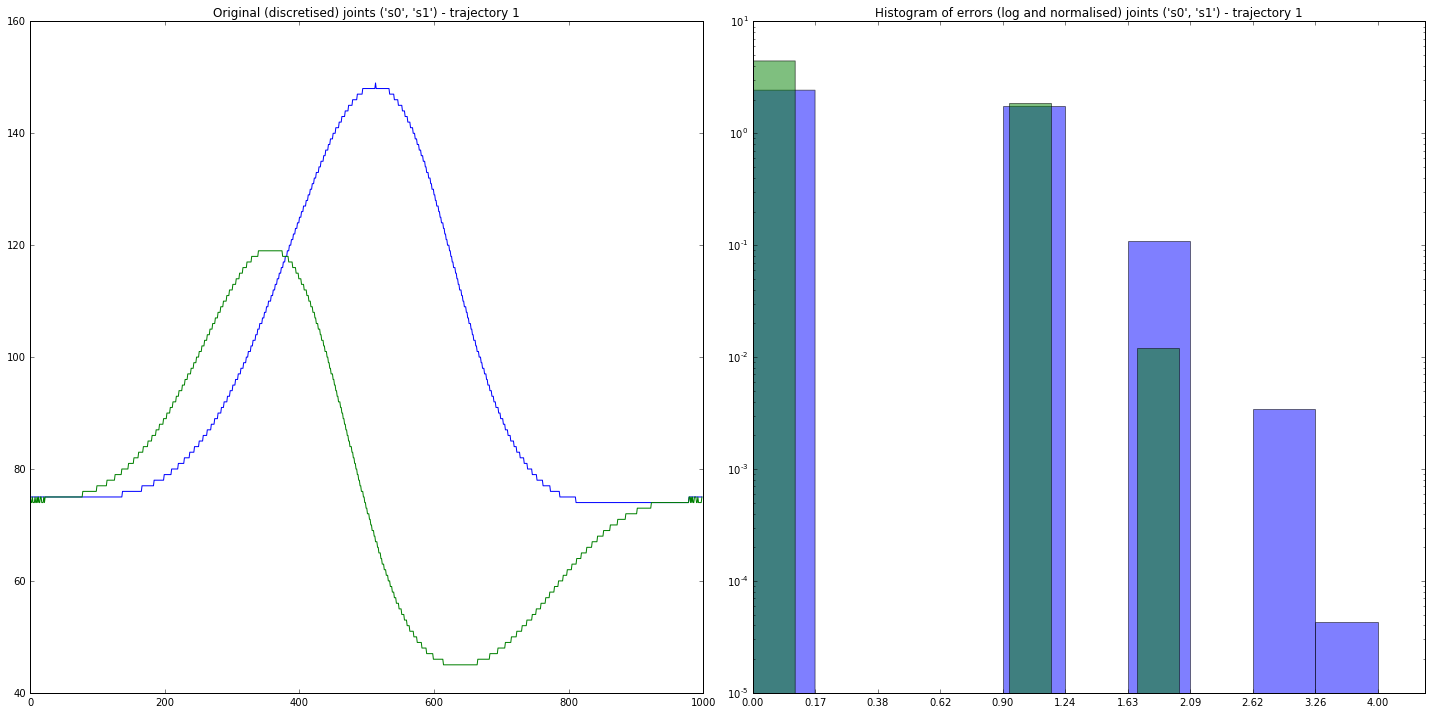

In [48]:
# Plots the inputs and the outputs side-by-side

joints_names = 's0','s1'

y_1 = joints_dict[joints_names[0]][0]
y_2 = joints_dict[joints_names[1]][0]
y1_calculated = joints_dict[joints_names[0]][1]
y2_calculated = joints_dict[joints_names[1]][1]

offset11 = y_1.shape[0]/number_of_trajectories
offset21 = y_2.shape[0]/number_of_trajectories

offset12 = y_1.shape[0]/number_of_trajectories/total_trials
offset22 = y_2.shape[0]/number_of_trajectories/total_trials


fig=plt.figure(figsize =(20,10));

for trajectory in xrange(number_of_trajectories):
# trajectory=0 # goes from 0 to 3

    ymax=numpy.array([y_1[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].max(),y_2[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].max()]).max()
    ymin=numpy.array([y_1[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].min(),y_2[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].min()]).min()

    ymaxLSM=numpy.array([y1_calculated[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].max(),y2_calculated[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].max()]).max()
    yminLSM=numpy.array([y1_calculated[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].min(),y2_calculated[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].min()]).min()

    j1=numpy.array([abs(joint_values_normalised-jin).argmin() for jin in y_1[trajectory*(offset11):offset11*trajectory+offset12]])
    j2=numpy.array([abs(joint_values_normalised-jin).argmin() for jin in y_2[trajectory*(offset21):offset21*trajectory+offset22]])
    plt.subplot(number_of_trajectories,2,2*trajectory+1)    
    plt.plot(j1,'b')
    plt.plot(j2,'g')

    plt.title("Original (discretised) joints "+ str(joints_names) +" - trajectory " + str(trajectory+1))

    plt.subplot(number_of_trajectories,2,2*trajectory+2)
    ans1 = []
    ans2 = []
    for ci in range(total_trials):
        j1ci = numpy.array([abs(joint_values_normalised-jin).argmin() for jin in (y1_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:])[ci,:]])
        j2ci = numpy.array([abs(joint_values_normalised-jin).argmin() for jin in (y2_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:])[ci,:]])
        ans1.append(abs(j1ci-j1))
        ans2.append(abs(j2ci-j2))

    ans1=numpy.concatenate(ans1)
    ans2=numpy.concatenate(ans2)    
    n, bins1, patches = plt.hist(numpy.log2(ans1+1),log=True,normed=True,alpha=0.5)
    n, bins2, patches = plt.hist(numpy.log2(ans2+1),log=True,normed=True,alpha=0.5)
    if max(bins1)>max(bins2):
        bins=bins1
    else:
        bins=bins2
    plt.xticks(bins, ["{0:.2f}".format(2**i-1) for i in bins])    
    plt.title("Histogram of errors (log and normalised) joints "+ str(joints_names) +" - trajectory " + str(trajectory+1))

# fig.subplots_adjust(bottom=0,hspace=.6) # Adjust the distance between subplots
plt.tight_layout()
# plt.savefig("./"+base_dir+"/"+sim_set+"/readout_test_s0_s1_"+sim_set+".pdf")
plt.show()

In [49]:
# Generates the discrete distribution
# The cell ABOVE must be execute JUST BEFORE THIS ONE!

ans1 = []
ans2 = []
for ci in range(total_trials):
    j1ci = numpy.array([abs(joint_values_normalised-jin).argmin() for jin in (y1_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:])[ci,:]])
    j2ci = numpy.array([abs(joint_values_normalised-jin).argmin() for jin in (y2_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:])[ci,:]])
    ans1.append((j1ci-j1))
    ans2.append((j2ci-j2))

ans1=numpy.concatenate(ans1)
ans2=numpy.concatenate(ans2)   

n1, bins1 = numpy.histogram(ans1)
n2, bins2 = numpy.histogram(ans2)

norm_distr1 = (n1*size_distr/n1.sum()).astype(dtype=numpy.int)
coeff_distr1 = (numpy.round(bins1)).astype(dtype=numpy.int)
norm_distr2 = (n2*size_distr/n2.sum()).astype(dtype=numpy.int)
coeff_distr2 = (numpy.round(bins2)).astype(dtype=numpy.int)

distr1 = numpy.zeros(len(numpy.unique(coeff_distr1)),dtype=numpy.int)
distr2 = numpy.zeros(len(numpy.unique(coeff_distr2)),dtype=numpy.int)

for i in range(len(norm_distr1)):
    distr1[abs(numpy.unique(coeff_distr1)-coeff_distr1[i]).argmin()]+=norm_distr1[i]
print distr1,numpy.unique(coeff_distr1)
filename = "./"+base_dir+"/"+sim_set+"/noise_distr_"+joints_names[0]+"_linear"+extra_name+".pickle"
if save2file:
    slf.save_to_file((size_distr,distr1,numpy.unique(coeff_distr1)),filename)

for i in range(len(norm_distr2)):
    distr2[abs(numpy.unique(coeff_distr2)-coeff_distr2[i]).argmin()]+=norm_distr2[i]
print distr2,numpy.unique(coeff_distr2)
filename = "./"+base_dir+"/"+sim_set+"/noise_distr_"+joints_names[1]+"_linear"+extra_name+".pickle"
if save2file:
    slf.save_to_file((size_distr,distr2,numpy.unique(coeff_distr2)),filename)

[   0  139    0 2057 5635 2042  123    0] [-4 -3 -2 -1  0  1  2  3]
[  11 1472 7028 1480    8] [-2 -1  0  1  2]


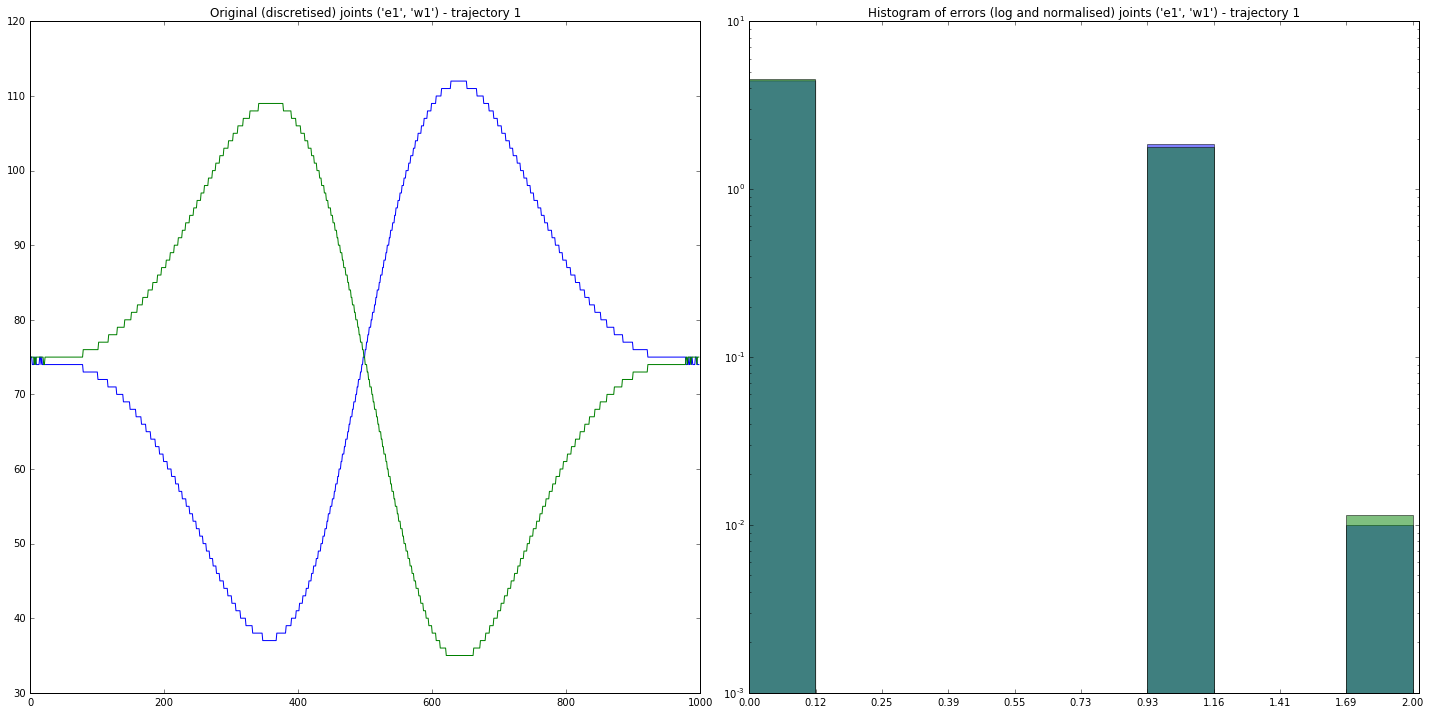

In [50]:
# Plots the inputs and the outputs side-by-side

joints_names = 'e1','w1'

y_1 = joints_dict[joints_names[0]][0]
y_2 = joints_dict[joints_names[1]][0]
y1_calculated = joints_dict[joints_names[0]][1]
y2_calculated = joints_dict[joints_names[1]][1]

offset11 = y_1.shape[0]/number_of_trajectories
offset21 = y_2.shape[0]/number_of_trajectories

offset12 = y_1.shape[0]/number_of_trajectories/total_trials
offset22 = y_2.shape[0]/number_of_trajectories/total_trials


fig=plt.figure(figsize =(20,10));

for trajectory in xrange(number_of_trajectories):
# trajectory=0 # goes from 0 to 3

    ymax=numpy.array([y_1[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].max(),y_2[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].max()]).max()
    ymin=numpy.array([y_1[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].min(),y_2[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].min()]).min()

    ymaxLSM=numpy.array([y1_calculated[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].max(),y2_calculated[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].max()]).max()
    yminLSM=numpy.array([y1_calculated[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].min(),y2_calculated[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].min()]).min()

    j1=numpy.array([abs(joint_values_normalised-jin).argmin() for jin in y_1[trajectory*(offset11):offset11*trajectory+offset12]])
    j2=numpy.array([abs(joint_values_normalised-jin).argmin() for jin in y_2[trajectory*(offset21):offset21*trajectory+offset22]])
    plt.subplot(number_of_trajectories,2,2*trajectory+1)    
    plt.plot(j1,'b')
    plt.plot(j2,'g')

    plt.title("Original (discretised) joints "+ str(joints_names) +" - trajectory " + str(trajectory+1))

    plt.subplot(number_of_trajectories,2,2*trajectory+2)
    ans1 = []
    ans2 = []
    for ci in range(total_trials):
        j1ci = numpy.array([abs(joint_values_normalised-jin).argmin() for jin in (y1_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:])[ci,:]])
        j2ci = numpy.array([abs(joint_values_normalised-jin).argmin() for jin in (y2_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:])[ci,:]])
        ans1.append(abs(j1ci-j1))
        ans2.append(abs(j2ci-j2))

    ans1=numpy.concatenate(ans1)
    ans2=numpy.concatenate(ans2)    
    n1, bins1, patches = plt.hist(numpy.log2(ans1+1),log=True,normed=True,alpha=0.5)
    n2, bins2, patches = plt.hist(numpy.log2(ans2+1),log=True,normed=True,alpha=0.5)
    if max(bins1)>max(bins2):
        bins=bins1
    else:
        bins=bins2
    plt.xticks(bins, ["{0:.2f}".format(2**i-1) for i in bins])    
    plt.title("Histogram of errors (log and normalised) joints "+ str(joints_names) +" - trajectory " + str(trajectory+1))

# fig.subplots_adjust(bottom=0,hspace=.6) # Adjust the distance between subplots
plt.tight_layout()
# plt.savefig("./"+base_dir+"/"+sim_set+"/readout_test_s0_s1_"+sim_set+".pdf")
plt.show()

In [51]:
# Generates the discrete distribution
# The cell ABOVE must be execute JUST BEFORE THIS ONE!

ans1 = []
ans2 = []
for ci in range(total_trials):
    j1ci = numpy.array([abs(joint_values_normalised-jin).argmin() for jin in (y1_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:])[ci,:]])
    j2ci = numpy.array([abs(joint_values_normalised-jin).argmin() for jin in (y2_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:])[ci,:]])
    ans1.append((j1ci-j1))
    ans2.append((j2ci-j2))

ans1=numpy.concatenate(ans1)
ans2=numpy.concatenate(ans2)   

n1, bins1 = numpy.histogram(ans1)
n2, bins2 = numpy.histogram(ans2)

norm_distr1 = (n1*size_distr/n1.sum()).astype(dtype=numpy.int)
coeff_distr1 = (numpy.round(bins1)).astype(dtype=numpy.int)
norm_distr2 = (n2*size_distr/n2.sum()).astype(dtype=numpy.int)
coeff_distr2 = (numpy.round(bins2)).astype(dtype=numpy.int)

distr1 = numpy.zeros(len(numpy.unique(coeff_distr1)),dtype=numpy.int)
distr2 = numpy.zeros(len(numpy.unique(coeff_distr2)),dtype=numpy.int)

for i in range(len(norm_distr1)):
    distr1[abs(numpy.unique(coeff_distr1)-coeff_distr1[i]).argmin()]+=norm_distr1[i]
print distr1,numpy.unique(coeff_distr1)
filename = "./"+base_dir+"/"+sim_set+"/noise_distr_"+joints_names[0]+"_linear"+extra_name+".pickle"
if save2file:
    slf.save_to_file((size_distr,distr1,numpy.unique(coeff_distr1)),filename)

for i in range(len(norm_distr2)):
    distr2[abs(numpy.unique(coeff_distr2)-coeff_distr2[i]).argmin()]+=norm_distr2[i]
print distr2,numpy.unique(coeff_distr2)
filename = "./"+base_dir+"/"+sim_set+"/noise_distr_"+joints_names[1]+"_linear"+extra_name+".pickle"
if save2file:
    slf.save_to_file((size_distr,distr2,numpy.unique(coeff_distr2)),filename)

[   6 1431 7016 1536    9] [-2 -1  0  1  2]
[  12 1570 7142 1268    5] [-2 -1  0  1  2]


# My theory here is that the input noise cannot be "any" input noise, but the one that best fits the behaviour of the current configuration.
# So I'm implementing a way to extract the distribution of the errors to use as the input noise distribution.

# I hope this is going to give me a way to improve the learning process...

# I want to understand why sometimes the linear regression can fit something that reproduces almost perfectly the joint curves, but the simulation using the same number of trials as parallel LSMs cannot?!?!?!?
- My answer to this is the LSM is very unstable to changes into the input values. According to the histograms it's possible to verify that there are a certain amount of errors even when NO noise is used (the seeds are always the same).

# Also I would like to understand better how to improve the linear regression. Should I simplify the network, change the neuron parameters, disable connections??? I need to verify the effects of the input noise (different distributions?), the effect of the noise inside the liquid and also the effect of the number of trials.

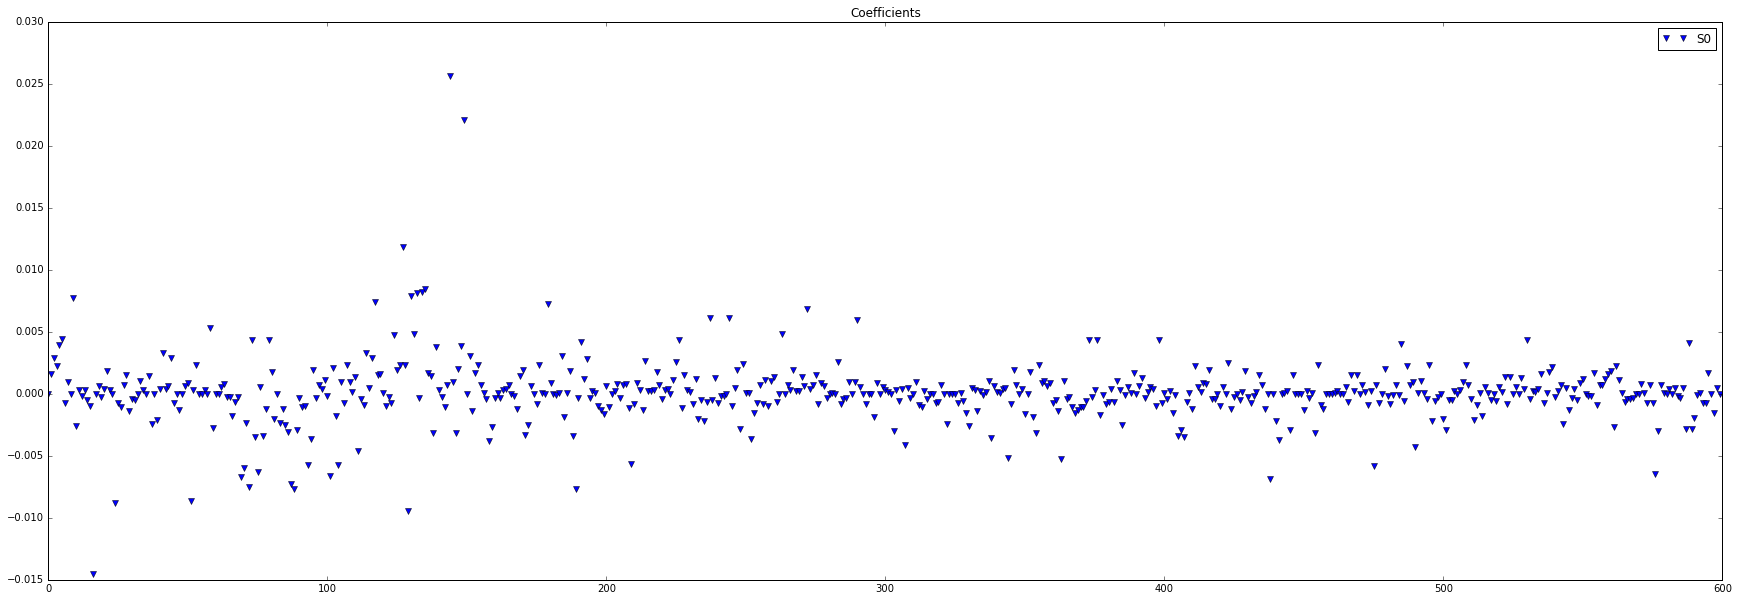

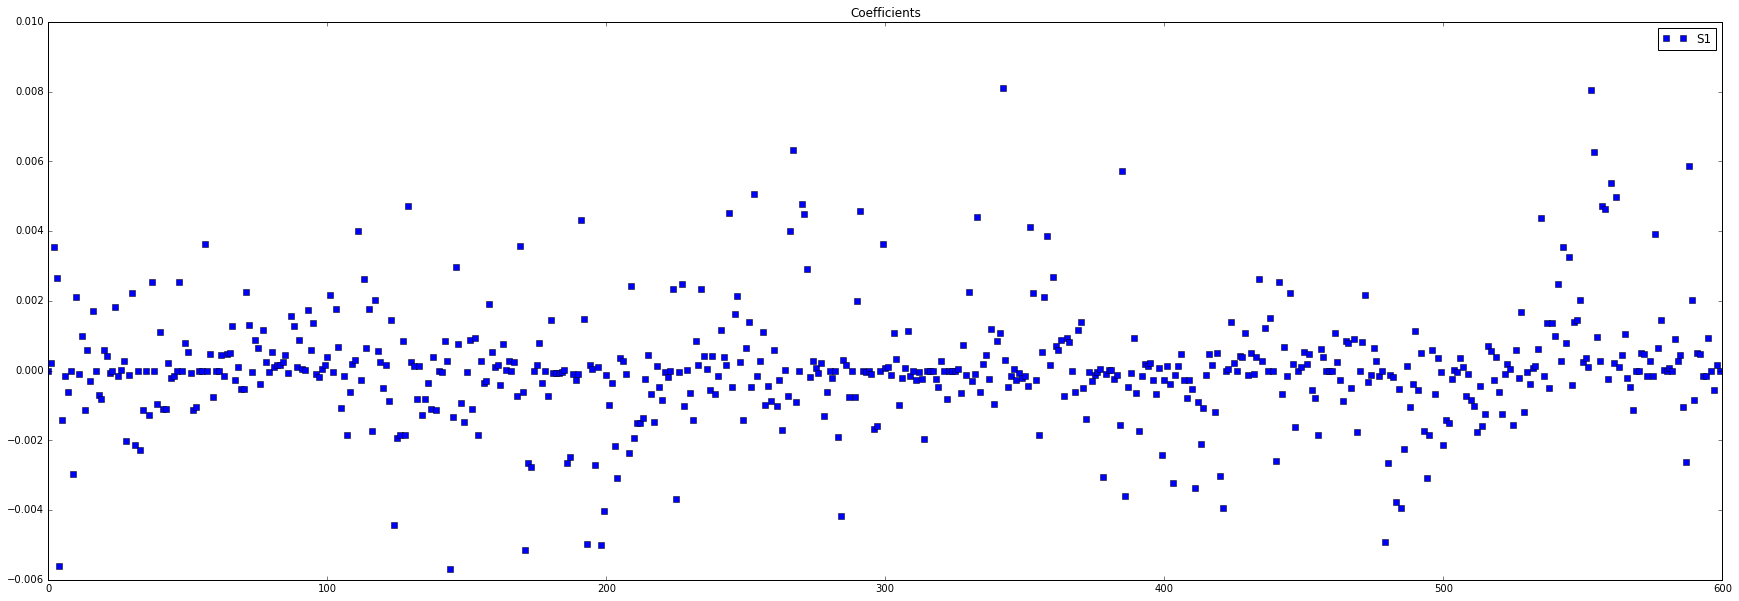

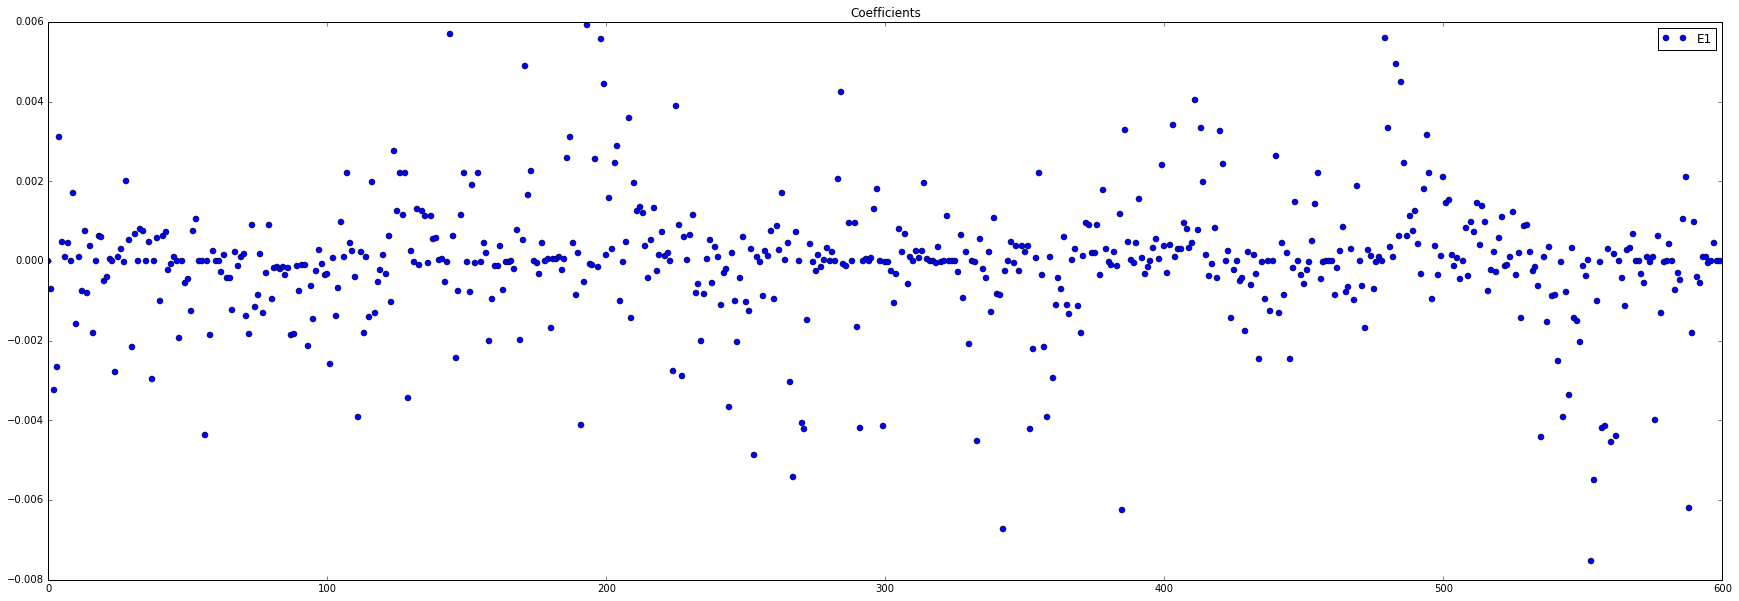

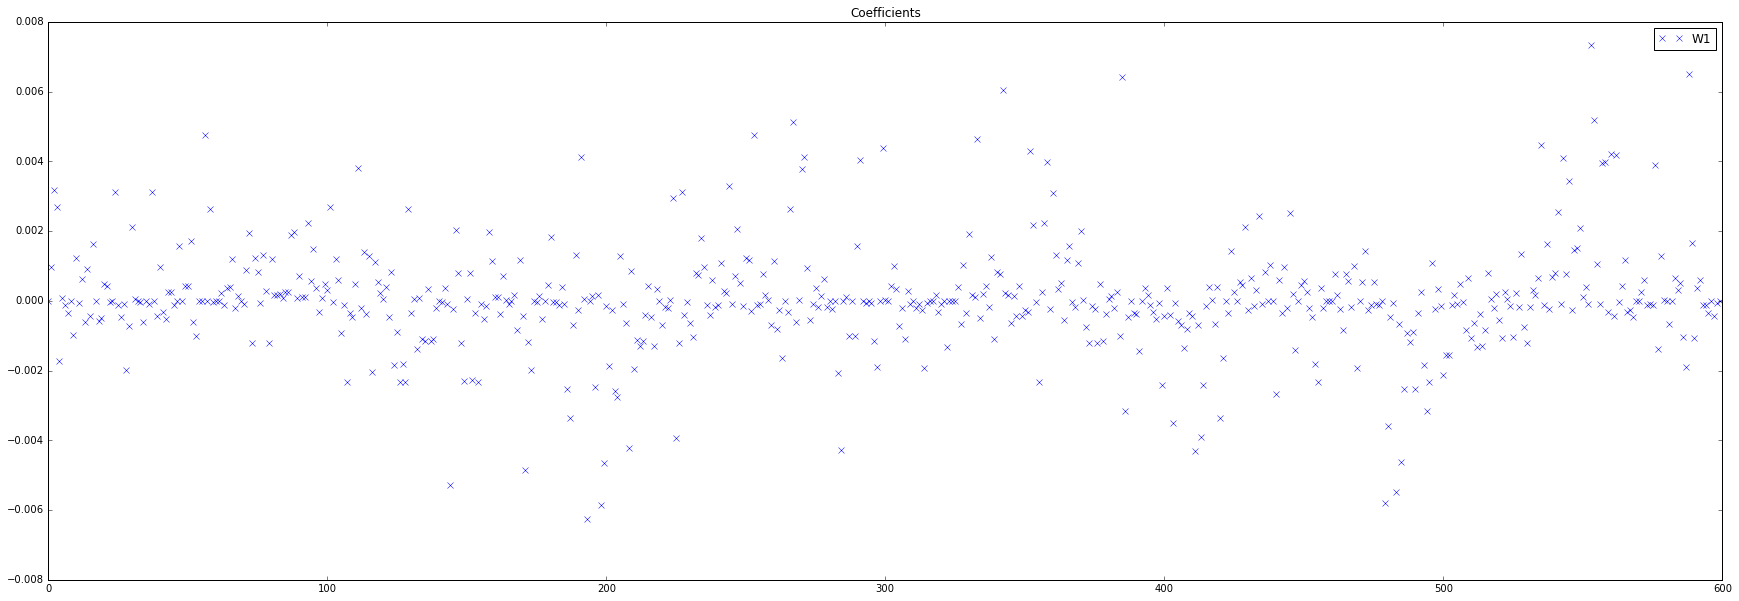

In [52]:
plt.rcParams['figure.figsize'] = 30, 10

# plt.figure(figsize =(30,10))
plt.plot(c_s0,'v',label="S0")
plt.title("Coefficients")
plt.legend()
plt.show()

plt.plot(c_s1,'s',label="S1")
plt.title("Coefficients")
plt.legend()
plt.show()

plt.plot(c_e1,'o',label="E1")
plt.title("Coefficients")
plt.legend()
plt.show()

plt.plot(c_w1,'x',label="W1")
plt.title("Coefficients")
plt.legend()
plt.show()

In [53]:
# Independent terms
r_s0,r_s1,r_e1,r_w1

# Independent terms close to zero are the result of the bias extraction (I force the curves to start at zero)

(0.0047465675837620735,
 0.0020133072427485355,
 -0.0010065985458799316,
 0.00060859453159394818)

# I don't have a good answer, but probably because of the way the linear regression is implemented (think about "inverting" non square matrices...) if more of the same data is added the result is different from the same data without (or with less) copies.

In [54]:
readout_w = [c_s0,c_s1,c_e1,c_w1]
readout_w_n = ['S0','S1','E1','W1'] 

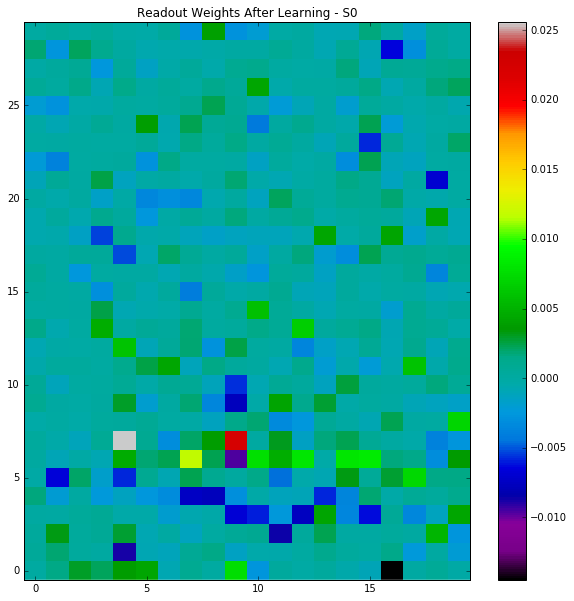

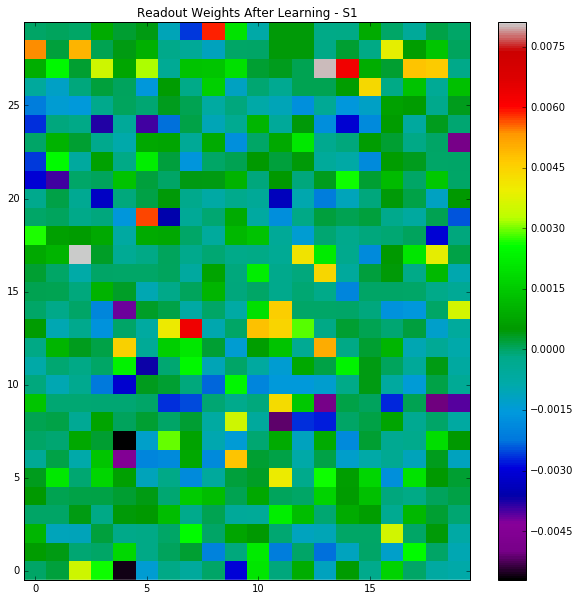

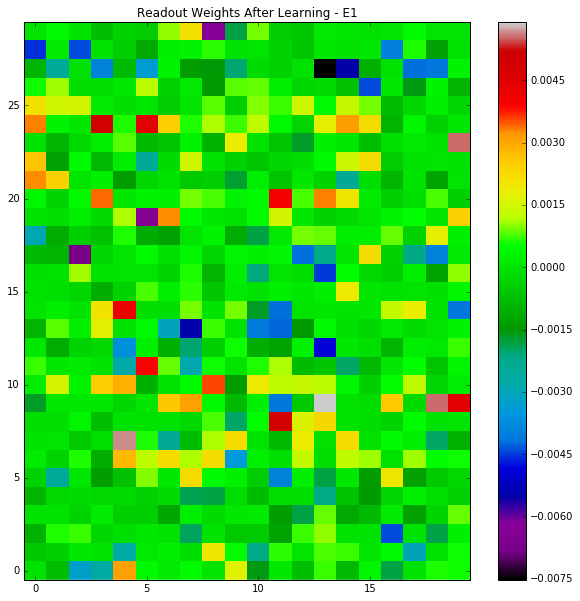

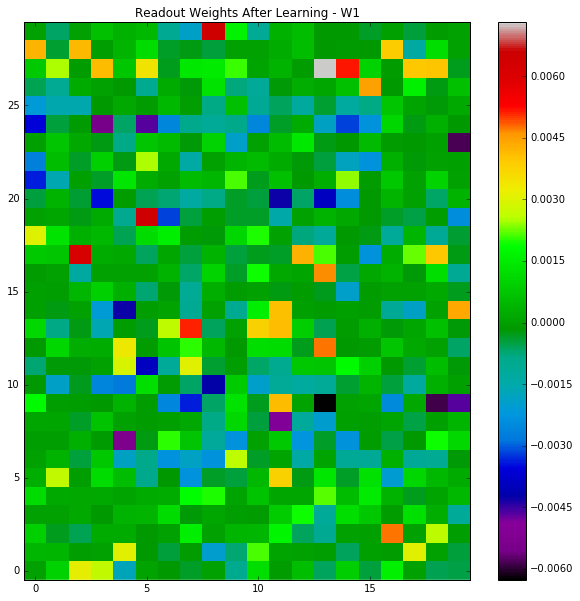

In [55]:
#
# Here the readout weights are plotted as a matrix instead of a line
# to make it easier to visualise / compare their values.
for wi,ti in zip(readout_w,readout_w_n):
    plt.figure(figsize =(10,10))
    plt.imshow(wi.reshape((30,20)), origin='lower', aspect='auto',interpolation='none')
    # plt.axis('off')
    plt.set_cmap('spectral')
    plt.colorbar()
    plt.title("Readout Weights After Learning - "+ti)
    plt.show()